# 2η Υποχρεωτική Εργασία
## Να γραφεί πρόγραμμα σε οποιαδήποτε γλώσσα προγραμματισμού το οποίο να υλοποιεί ένα Support Vector Machine που θα εκπαιδευτεί για να επιλύει το παρακάτω προβλήματα:
### Αναγνώριση μονών και ζυγών αριθμών στα δεκαδικά ψηφία (0,1,...,9) της MNIST

<h3> Imports </h3>
<p> Σε αυτό το cell έχουμε όλα τα imports που θα χρειαστούμε στο notebook.</p>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.datasets import mnist
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import time

#in order to reproduce the same results every time
tf.random.set_seed(7)
RANDOM_STATE = 42

<h3>Φορτώνουμε το σύνολο δεδομένων μέσα από το Keras.</h3>
<p>Το Training set αποτελείται 60k εικόνες και το Test set αποτελείται από 10k εικόνες.</p>
<p>Κάθε εικόνα έχει διστάσεις 28x28 pixels σε Grayscale (δηλαδή έχουμε 1 channel, σε αντίθεση με το rgb που έχει 3 channels) και το label κάθε εικόνας είναι μηδέν εάν ο αριθμός είναι άρτιος (even number) ή άσσος εάν ο αριθμός που αναπαριστά η εικόνα είναι περιττός (odd number)(δηλαδή πρόκειται για ένα binary classifiaction task).</p>
<p>Κάθε pixel παίρνει τιμή από 0 έως 255, 0 για τα άσπρα pixels και 255 για τα μαύρα pixels</p>

In [2]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
Y_train = Y_train % 2
Y_test = Y_test % 2
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(Y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(Y_test.shape))
print("Labels: " + str(np.unique(Y_train))) #μοναδικές τιμές του Y_train (προφανώς έχουμε τις ίδιες μοναδικές τιμές και στο Y_test)

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)
Labels: [0 1]


<h3>Τυπώνουμε την 1η και την τελευταία εικόνα του Training Set μαζί με τα αντίστοιχα labels</h3>

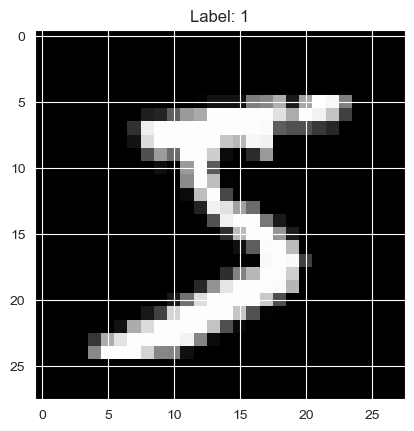

In [87]:
plt.imshow(X_train[0], cmap='gray', vmin=0, vmax=255)
plt.title(f"Label: {Y_train[0]}")
plt.show()

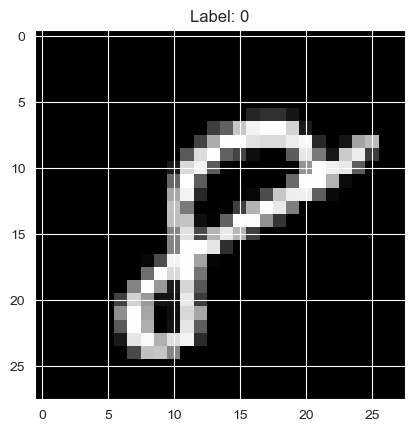

In [17]:
plt.imshow(X_train[-1], cmap='gray', vmin=0, vmax=255)
plt.title(f"Label: {Y_train[-1]}")
plt.show()

<h3>Class Imbalance Check</h3>
<h4>Έλεγχος εάν κάθε μία κλάση έχει περίπου τον ίδιο αριθμό από training examples</h4>

Text(0.5, 1.0, 'Πλήθος παραδειγμάτων ανά κλάση')

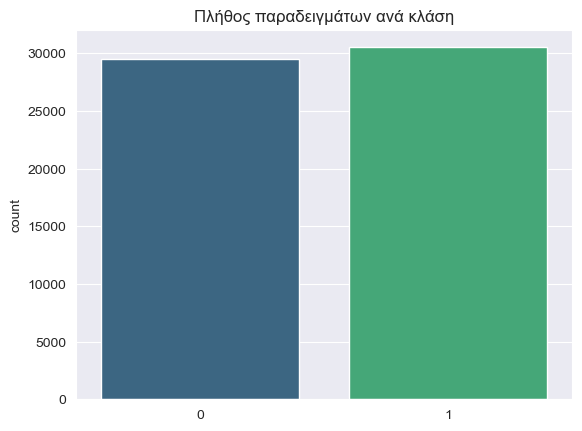

In [18]:
sns.countplot(x = Y_train, palette = "viridis")
plt.title("Πλήθος παραδειγμάτων ανά κλάση")

<h4>Παρατηρούμε ότι δεν υπάρχει class imbalance, καθώς έχουμε ισότιμη κατανομή (distribution) των training examples σε κάθε μία πό τις δύο κλάσεις.</h4>

<h3>Προετοιμασία των Data για να τα δώσουμε στη συνέχεια στα μοντέλα.</h3>

<h4>Κάθε training example είναι στη μορφή ενός δισδιάστατου πίνακα διαστάσεων 28x28. Επειδή δεν μπορούμε να τροφοδοτήσουμε τα δεδομένα στα μοντέλα μας με αυτήν τη δισδιάστατη μορφή, μετασχηματίζουμε κάθε training example ώστε να έχει τη μορφή ενός διανύσματος(one dimension array). </h4>

In [3]:
# Flattening
X_train = X_train.reshape((-1,28*28))
X_test = X_test.reshape((-1, 28*28))
print('X_train: ' + str(X_train.shape))
print('X_test: ' + str(X_test.shape))

X_train: (60000, 784)
X_test: (10000, 784)


<h1>Πειραματισμοί που σχετίζονται με το κομμάτι του learning, όπως αυτό περιγράφηκε και αναλύθηκε στις διαλέξεις του μαθήματος.</h1>
<h3>Πιο συγκεκριμένα, θα αναλυθούν τα εξής:</h3>
<ol>
<li>Κανονικοποίηση των Δεδομένων</li>
<li>Χρήση διαφορετικών τιμών για την υπέρ-παράμετρο C (Regularization parameter) και διαφορετικών τύπων από Kernels</li>
<li>Hyper-parameter tuning με διαδοχικά Cross Validation</li>
<li>Εκπαίδευση σε όλο το Data Set με το καλύτερο set υπέρ-παραμέτρων</li>
<li>Primal vs Dual space</li>
<li>KNN vs NCC vs SVM</li>
<li>Παραδείγματα Ορθής και Εσφαλμένης Κατηγοριοποίησης</li>
</ol>

## 1. Κανονικοποίηση των Δεδομένων (Data Scaling)
### Στο συγκεκριμένο πείραμα θα προσπαθήσουμε να αναδείξουμε ποιες είναι οι διαφορετικές μορφές κανονικοποίησης και πως αυτές επηρεάζουν την εκπαίδευση των μοντέλων. Πιο συγκεκριμένα, θα εξεταστούν οι εξής περιπτώσεις:
- Normalization των δεδομένων στο διάστημα [0,1]
- Normalization των δεδομένων στο διάστημα [-1,1]
- Standardization των δεδομένων
- Χειροκίνητη (manual) κανονικοποίηση των δεδομένων
- ΜΗ κανονικοποίηση των δεδομένων


#### Case 1: Normalization των δεδομένων στο διάστημα [0,1]

In [35]:
scaler = MinMaxScaler(feature_range=(0, 1)) # Όλες οι τιμές κάθε μεταβλητής εισόδου θα είναι στο εύρος από 0 έως 1
X_train_Normalization_0_1 = scaler.fit_transform(X_train)
X_test_Normalization_0_1 = scaler.transform(X_test) #Στο Test set δεν κάνουμε fit_transform, αλλά σκέτο transform
svm_Normalization_0_1 = LinearSVC(dual=False,max_iter=100000)
start_time = time.time()
svm_Normalization_0_1.fit(X_train_Normalization_0_1,Y_train)
end_time = time.time()
total_time_fit_Normalization_0_1 = end_time - start_time

#### Case 2: Normalization των δεδομένων στο διάστημα [-1,1]

In [36]:
scaler = MinMaxScaler(feature_range=(-1, 1)) # Όλες οι τιμές κάθε μεταβλητής εισόδου θα είναι στο εύρος από -1 έως 1
X_train_Normalization_1_1 = scaler.fit_transform(X_train)
X_test_Normalization_1_1 = scaler.transform(X_test) #Στο Test set δεν κάνουμε fit_transform, αλλά σκέτο transform
svm_Normalization_1_1 = LinearSVC(dual=False,max_iter=100000)
start_time = time.time()
svm_Normalization_1_1.fit(X_train_Normalization_1_1,Y_train)
end_time = time.time()
total_time_fit_Normalization_1_1 = end_time - start_time

#### Case 3: Standardization των δεδομένων

In [37]:
scaler_train = StandardScaler().fit(X_train)
X_train_Standardization = scaler_train.transform(X_train)
X_test_Standardization = scaler_train.transform(X_test)
svm_Standardization = LinearSVC(dual=False,max_iter=100000)
start_time = time.time()
svm_Standardization.fit(X_train_Standardization,Y_train)
end_time = time.time()
total_time_fit_Standardization = end_time - start_time

#### Case 4: Χειροκίνητη (manual) κανονικοποίηση των δεδομένων
- Εφόσον ξέρουμε ότι τα δεδομένα μας σε κάθε διάσταση είναι ένας αριθμός από το 0 έως το 255 κάνουμε μια χειροκίνητη (manual) κανονικοποίηση των δεδομένων ώστε όλες οι τιμές του Data Set να έρθουν στο εύρος [0,1]. Αυτό το πετυχαίνουμε διαιρώντας όλες τις τιμές με το 255.
- Ο MinMax scaler της sklearn πηγαίνει σε κάθε feature του Data Set και βρίσκει τη μέγιστη και την ελάχιστη τιμή του και με βάση αυτές κάνει την κανονικοποίηση. Ωστόσο, υπάρχει περίπτωση σε κάποιο feature να μην έχουμε το πλήρως εύρος τιμών, δηλαδή η ελάχιστη τιμή να μην είναι το μηδέν και η μέγιστη τιμή να μην είναι το 255, και αυτό θα δυσκολέψει το μοντέλο κατά το predict όπου μπορεί να συναντήσει τιμές εκτός του εύρους τιμών που εκπαιδεύτηκε. Για αυτόν τον λόγο σε tasks όπου ξέρουμε το ποιο είναι το εύρος των τιμών που μπορούν να πάρουν τα features μας (όπως αυτό που έχουμε - MNIST) είναι προτιμητέα η χειροκίνητη κανονικοποίηση των δεδομένων.

In [38]:
X_train_Manual = X_train / 255.0
X_test_Manual = X_test / 255.0
svm_Manual = LinearSVC(dual=False,max_iter=100000)
start_time = time.time()
svm_Manual.fit(X_train_Manual,Y_train)
end_time = time.time()
total_time_fit_Manual = end_time - start_time

#### Case 5: ΜΗ κανονικοποίηση των δεδομένων
- Δεν κάνουμε κάποιο scale στο Data Set.

In [39]:
svm_Without_Scaling = LinearSVC(dual=False,max_iter=100000)
start_time = time.time()
svm_Without_Scaling.fit(X_train,Y_train)
end_time = time.time()
total_time_fit_Without_Scaling = end_time - start_time

### Σύγκριση του χρόνου εκπαίδευσης σε κάθε μία από τις 5 περιπτώσεις

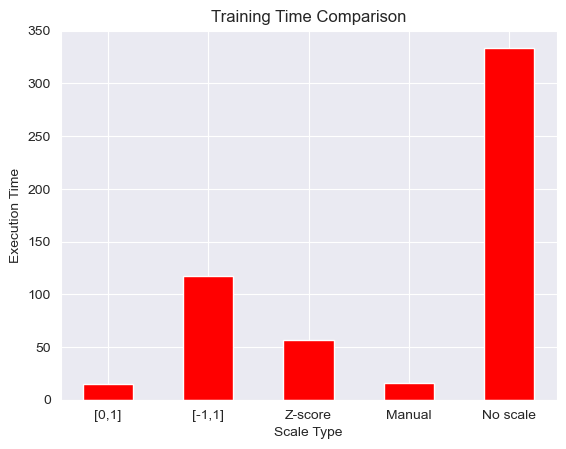

In [47]:
# Data for the bar plot
scale_type = ["[0,1]", "[-1,1]", "Z-score", "Manual", "No scale"]
execution_time = [total_time_fit_Normalization_0_1, total_time_fit_Normalization_1_1, total_time_fit_Standardization, total_time_fit_Manual, total_time_fit_Without_Scaling]

# Create the bar plot
plt.bar(scale_type, execution_time, color='red', width=0.5, align='center')

# Add a title and axis labels
plt.title("Training Time Comparison")
plt.xlabel("Scale Type")
plt.ylabel("Execution Time")

# Show the plot
plt.show()

### Σύγκριση του accuracy σε άγνωστα δεδομένα σε κάθε μία από τις 5 περιπτώσεις

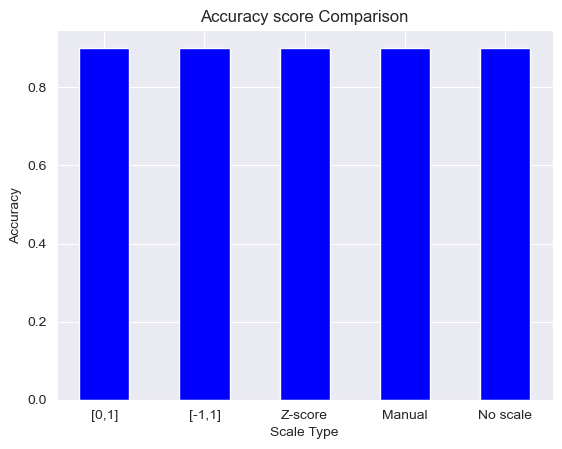

In [54]:
# Data for the bar plot
scale_type = ["[0,1]", "[-1,1]", "Z-score", "Manual", "No scale"]
accuracy = [svm_Normalization_0_1.score(X_test_Normalization_0_1,Y_test), svm_Normalization_1_1.score(X_test_Normalization_1_1,Y_test), svm_Standardization.score(X_test_Standardization,Y_test), svm_Manual.score(X_test_Manual,Y_test), svm_Without_Scaling.score(X_test,Y_test)]

# Create the bar plot
plt.bar(scale_type, accuracy, color='blue', width=0.5, align='center')

# Add a title and axis labels
plt.title("Accuracy score Comparison")
plt.xlabel("Scale Type")
plt.ylabel("Accuracy")

# Show the plot
plt.show()

In [56]:
print(f"Accuracy scores: {accuracy}")

Accuracy scores: [0.9016, 0.9008, 0.9013, 0.9012, 0.901]


### Παρατηρήσεις:
- Το scaling των δεδομένων γενικότερα στα SVMs(που είναι Distance Based Αλγόριθμος) είναι αρκετά χρήσιμο:
- Έχει θετική επίδραση στην ταχύτητα σύγκλισης του αλγορίθμου βελτιστοποίησης (πιο γρήγορη σύγκλιση). Η LIBLINEAR χρησιμοποιεί τον coordinate descent optimization algorithm ως optimizer όταν λύνει το πρόβλημα στον primal space και το να κάνουμε scale τα δεδομένα ώστε να είναι όλα τα features στην ίδια κλίμακα βελτιώνει σημαντικά τον χρόνο που χρειάζεται για να εκπαιδευτεί το μοντέλο. Άλλωστε αυτό αποτυπώνεται και στο bar plot με το "Training Time Comparison" όπου βλέπουμε πως οι εκπαιδεύσεις με τα scaled data είναι πολύ πιο γρήγορες.
- Το SVM έχει συνήθως καλύτερο performance (γενικεύει καλύτερα) όταν όλα τα features είναι στην ίδια κλίμακα γιατί είναι ένας αλγόριθμος που βασίζεται στις αποστάσεις μεταξύ των δειγμάτων, και συνεπώς σε μια τέτοια περίπτωση διασφαλίζουμε ότι όλα τα features θα έχουν την ίδια επίδραση στα distance metrics και δεν κυριαρχούνται από κάποιο feature με μεγάλο scale. Στο δικό μας task, ωστόσο, παρατηρούμε πως το scale των δεδομένων δεν έχει κάποια ιδιαίτερη επίδραση στο performance του μοντέλου. Αυτό μπορεί να συμβαίνει επειδή τα features είναι ήδη σε παρόμοιο scale.


### Αξίζει να σημειωθεί πως όταν ένα μοντέλο που έχει εκπαιδευτεί σε ένα range τιμών (π.χ. στο [0,1]) και χρησιμοποιηθεί για να κάνει inference σε ένα Data Set που είναι σε διαφορετικό εύρος τιμών σε σχέση με αυτό που εκπαιδεύτηκε θα έχει χειρότερη απόδοση σε σχέση με το να έκανε inference στο εύρος τιμών που είχε εκπαιδευτεί. Για παράδειγμα:

In [62]:
print(f"Inference στο εύρος τιμών που εκπαιδεύτηκε ([0,1]): accuracy={svm_Normalization_0_1.score(X_test_Normalization_0_1,Y_test)}")
print(f"Inference σε διαφορετικό εύρος τιμών ([0,255]): accuracy={svm_Normalization_0_1.score(X_test,Y_test)}")

Inference στο εύρος τιμών που εκπαιδεύτηκε ([0,1]): accuracy=0.9016
Inference σε διαφορετικό εύρος τιμών ([0,255]): accuracy=0.8613


## 2. Χρήση διαφορετικών τιμών για την υπέρ-παράμετρο C (Regularization parameter) και διαφορετικών τύπων από Kernels
- Στα παρακάτω πειράματα θα χρησιμοποιήσουμε μόνο το 1/6 του Training Data Set (δηλαδή 10.000 δείγματα) και στην παράμετρο max_iter θα βάλουμε μια σχετικά μικρή τιμή (1000) με αποτέλεσμα να έχουμε Convergence Warning κατά την εκπαίδευση.

In [4]:
num_of_training_samples = 10000
X_train_Manual = X_train / 255.0
X_test_Manual = X_test / 255.0

#### Polynomial Kernel με fixed C

In [13]:
for degree in [3, 7, 11, 15]:
    svm = SVC(C=1, kernel='poly', degree=degree, max_iter=1000)
    svm.fit(X_train_Manual[:num_of_training_samples],Y_train[:num_of_training_samples])
    print(f"Degree = {degree}, Train accuracy: {100*svm.score(X_train_Manual[:num_of_training_samples],Y_train[:num_of_training_samples])}, Test Accuracy: {100*svm.score(X_test_Manual, Y_test)}")
    print(f"Πλήθος των support vectors: {svm.support_vectors_.shape[0]}")

C:\Users\User\anaconda3\envs\MLenv\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Degree = 3, Train accuracy: 98.92999999999999, Test Accuracy: 96.84
Πλήθος των support vectors: 1727


C:\Users\User\anaconda3\envs\MLenv\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Degree = 7, Train accuracy: 80.61, Test Accuracy: 80.22
Πλήθος των support vectors: 1954


C:\Users\User\anaconda3\envs\MLenv\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Degree = 11, Train accuracy: 70.08, Test Accuracy: 68.7
Πλήθος των support vectors: 1955


C:\Users\User\anaconda3\envs\MLenv\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Degree = 15, Train accuracy: 67.2, Test Accuracy: 65.7
Πλήθος των support vectors: 1906


#### Παρατηρήσεις:
- Παρατηρούμε ότι καθώς αυξάνεται ο βαθμός του polynomial kernel (και άρα αυξάνεται και το complexity του μοντέλου) η επίδοση του μοντέλου μειώνεται αισθητά τόσο στο Training όσο και στο Test set. Για παράδειγμα, θα περίμενε κάποιος πως για degree = 15 όπου το μοντέλο έχει πολύ capacity θα μάθαινε τέλεια τα δεδομένα εκπαίδευσης (over-fit) ενώ στα άγνωστα δεδομένα δε θα είχε τόσο καλή επίδοση. Ωστόσο, στην συγκεκριμένη περίπτωση παρατηρούμε ότι μοντέλο έχει εξαιρετικά κακές επιδόσεις και μάλλον ο λόγος που συμβαίνει αυτό είναι το γεγονός ότι με έναν τόσο μεγάλο βαθμού πολυωνύμου έχουμε πιθανώς ξεπεράσει στα όρια της υπολογιστικής ακρίβειας της μηχανής. Για αυτόν τον λόγο συνήθως δε βάζουμε πολύ μεγάλο βαθμό πολυωνύμου (πχ μέχρι degree = 9) για να μην έχουμε προβλήματα αριθμητικής ευστάθειας.
- Το πλήθος των support vectors είναι το λίγο λιγότερο του 1/5 του Training Set σε όλες τις περιπτώσεις.

#### Διάφορες τιμές του C με fixed Polynomial Kernel

In [15]:
for C in [0.01, 0.1, 1, 10, 100, 1000]:
    svm = SVC(C=C, kernel='poly', degree=3, max_iter=1000)
    svm.fit(X_train_Manual[:num_of_training_samples],Y_train[:num_of_training_samples])
    print(f"C = {C}, Train accuracy: {100*svm.score(X_train_Manual[:num_of_training_samples],Y_train[:num_of_training_samples])}, Test Accuracy: {100*svm.score(X_test_Manual, Y_test)}")
    print(f"Πλήθος των support vectors: {svm.support_vectors_.shape[0]}")

C:\Users\User\anaconda3\envs\MLenv\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


C = 0.01, Train accuracy: 53.87, Test Accuracy: 54.21
Πλήθος των support vectors: 2000


C:\Users\User\anaconda3\envs\MLenv\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


C = 0.1, Train accuracy: 63.22, Test Accuracy: 63.31
Πλήθος των support vectors: 2000


C:\Users\User\anaconda3\envs\MLenv\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


C = 1, Train accuracy: 98.92999999999999, Test Accuracy: 96.84
Πλήθος των support vectors: 1727


C:\Users\User\anaconda3\envs\MLenv\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


C = 10, Train accuracy: 99.95, Test Accuracy: 97.23
Πλήθος των support vectors: 1261


C:\Users\User\anaconda3\envs\MLenv\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


C = 100, Train accuracy: 100.0, Test Accuracy: 97.1
Πλήθος των support vectors: 1227


C:\Users\User\anaconda3\envs\MLenv\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


C = 1000, Train accuracy: 100.0, Test Accuracy: 97.1
Πλήθος των support vectors: 1227


#### Παρατηρήσεις:
- Όταν το C είναι μικρό είναι σαν να λέμε στο μοντέλο πως δε μας πειράζει να βάλει και κάποια δείγματα εκτός της σωστής πλευράς του διαχωριστικού υπερεπιπέδου αρκεί να μεγιστοποιήσει το margin. Γνωρίζουμε από τη θεωρία ότι μόνο όσα δείγματα είναι στη λάθος πλευρά του υπερεπιπέδου ή βρίσκονται πάνω στο ένα από τα δύο -παράλληλα ως προς το διαχωριστικό- υπερεπίπεδα. Συνεπώς, όταν έχουμε μεγάλο Margin (δηλαδή μικρό C) όλο και πιο πολλά δείγματα εμπίπτουν σε μία από τις 2 περιπτώσεις που αναφέραμε προηγουμένως και άρα έχουμε και πιο πολλά σε πλήθος support vectors.
- Αντίθετα, όταν το C αυξάνεται είναι σαν να λέμε στο μοντέλο πως μας ενδιαφέρει να μην κάνει σφάλματα και συνεπώς το margin μειώνεται και κατ' επέκταση και το πλήθος των support vectors μειώνεται.
- Πράγματι, για C = 0.01 έχουμε 2000 support vectors, ενώ για C = 1000 έχουμε λιγότερα support vectors (1227 support vectors).
- Επιπλέον, για τους λόγους που αναφέραμε στα προηγούμενα bullets παρατηρούμε πως καθώς αυξάνεται το C αυξάνεται και η ικανότητα του μοντέλου να μάθει το task.

#### Διάφορες τιμές του C με χρήση RBF (Radial Basis Function) kernel

In [6]:
for C in [0.01, 0.1, 1, 10, 100, 1000]:
    svm = SVC(C=C, kernel='rbf', max_iter=1000)
    svm.fit(X_train_Manual[:num_of_training_samples],Y_train[:num_of_training_samples])
    print(f"C = {C}, Train accuracy: {100*svm.score(X_train_Manual[:num_of_training_samples],Y_train[:num_of_training_samples])}, Test Accuracy: {100*svm.score(X_test_Manual, Y_test)}")
    print(f"Πλήθος των support vectors: {svm.support_vectors_.shape[0]}")

C:\Users\User\anaconda3\envs\MLenv\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


C = 0.01, Train accuracy: 74.22, Test Accuracy: 74.89
Πλήθος των support vectors: 2000


C:\Users\User\anaconda3\envs\MLenv\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


C = 0.1, Train accuracy: 95.25, Test Accuracy: 93.83
Πλήθος των support vectors: 2000


C:\Users\User\anaconda3\envs\MLenv\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


C = 1, Train accuracy: 98.86, Test Accuracy: 97.16
Πλήθος των support vectors: 1759


C:\Users\User\anaconda3\envs\MLenv\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


C = 10, Train accuracy: 99.98, Test Accuracy: 97.83
Πλήθος των support vectors: 1363


C:\Users\User\anaconda3\envs\MLenv\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


C = 100, Train accuracy: 100.0, Test Accuracy: 97.86
Πλήθος των support vectors: 1348


C:\Users\User\anaconda3\envs\MLenv\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


C = 1000, Train accuracy: 100.0, Test Accuracy: 97.86
Πλήθος των support vectors: 1348


#### Παρατηρήσεις:
- Παρατηρούμε αντίστοιχα αποτελέσματα με αυτά που είχαμε και στην περίπτωση όπου δοκιμάζαμε διάφορες τιμές του C με polynomial kernel (δηλαδή αυξάνοντας την τιμή του C αυξάνεται και η δυνατότητα του μοντέλου να μάθει ώσπου φτάνει στο σημείο να έχει "παπαγαλίσει" όλο το Training Set) με τη μόνη διαφορά πως ακόμα και με πολύ μικρό C (πχ C = 0.01) το SVM με RBF kernel πετυχαίνει ικανοποιητικά αποτελέσματα.
- Για παράδειγμα, για C = 0.01 με RBF έχουμε 74.89 acc. στο Test, ενώ με Polynomial έχουμε 54.21
- Έχοντας μάλιστα υπόψη ότι οι polynomial kernels παρουσιάζουν προβλήματα αριθμητικής αστάθειας καταλαβαίνουμε γιατί ο RBF kernel είναι πρώτη μας επιλογή σε σχέση με τον polynomial (αλλά και με τον sigmoid όπου συνήθως παρουσιάζει προβλήματα).

#### Διάφορες τιμές του gamma RBF kernel με fixed C

In [18]:
for gamma in [0.01, 0.1, 1, 10, 100, 1000]:
    svm = SVC(C=1, kernel="rbf",gamma=gamma, max_iter=1000)
    svm.fit(X_train_Manual[:num_of_training_samples],Y_train[:num_of_training_samples])
    print(f"Gamma = {gamma}, Train accuracy: {100*svm.score(X_train_Manual[:num_of_training_samples],Y_train[:num_of_training_samples])}, Test Accuracy: {100*svm.score(X_test_Manual, Y_test)}")
    print(f"Πλήθος των support vectors: {svm.support_vectors_.shape[0]}")

C:\Users\User\anaconda3\envs\MLenv\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Gamma = 0.01, Train accuracy: 98.37, Test Accuracy: 96.85000000000001
Πλήθος των support vectors: 1835


C:\Users\User\anaconda3\envs\MLenv\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Gamma = 0.1, Train accuracy: 100.0, Test Accuracy: 97.72
Πλήθος των support vectors: 2000


C:\Users\User\anaconda3\envs\MLenv\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Gamma = 1, Train accuracy: 98.6, Test Accuracy: 95.3
Πλήθος των support vectors: 2000


C:\Users\User\anaconda3\envs\MLenv\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Gamma = 10, Train accuracy: 95.49, Test Accuracy: 94.85
Πλήθος των support vectors: 2000


C:\Users\User\anaconda3\envs\MLenv\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Gamma = 100, Train accuracy: 60.709999999999994, Test Accuracy: 50.74999999999999
Πλήθος των support vectors: 2000


C:\Users\User\anaconda3\envs\MLenv\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Gamma = 1000, Train accuracy: 60.699999999999996, Test Accuracy: 50.739999999999995
Πλήθος των support vectors: 2000


#### Παρατηρήσεις:
- Παρατηρούμε ότι για μικρές τιμές του gamma (δηλαδή η γκαουσιανή είναι wide) το SVM μαθαίνει καλύτερα το task. Αντίθετα, για μεγάλες τιμές του gamma (δηλαδή η γκαουσιανή είναι πολύ narrow) το SVM υπέρ-εκπαιδεύεται και πετυχαίνει πολύ χαμηλό accuracy.

#### Linear Kernel ως ειδική περίπτωση του RBF kernel

In [21]:
linear_svm = SVC(C=1, kernel="linear", max_iter=1000)
svm.fit(X_train_Manual[:num_of_training_samples],Y_train[:num_of_training_samples])
print(f"Linear Kernel, Train accuracy: {100*svm.score(X_train_Manual[:num_of_training_samples],Y_train[:num_of_training_samples])}, Test Accuracy: {100*svm.score(X_test_Manual, Y_test)}")
print(f"Πλήθος των support vectors: {svm.support_vectors_.shape[0]}")

C:\Users\User\anaconda3\envs\MLenv\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Linear Kernel, Train accuracy: 60.699999999999996, Test Accuracy: 50.739999999999995
Πλήθος των support vectors: 2000


### Παρατηρήσεις:
- Ο γραμμικός (linear) kernel είναι μια ειδική περίπτωση του RBF. Αυτό φαίνεται και από το γεγονός πως για gamma = 1000 παίρνουμε ακριβώς τα ίδια αποτελέσματα με τον linear kernel.

## 3. Hyper-parameter tuning με διαδοχικά Cross Validation

#### Συνεπώς, όταν εκπαιδεύουμε ένα SVM με RBF Kernel έχουμε 2 υπέρ-παραμέτρους να ρυθμίσουμε: C και gamma. Αυτές πρέπει να ρυθμιστούν ταυτόχρονα και συνεπώς χρειάζεται να ψάξουμε τον καλύτερο συνδυασμό τους. Αυτό το πετυχαίνουμε κάνοντας cross validation.
#### Πιο συγκεκριμένα, στη συνέχεια χρησιμοποιούμε RandomizedSearchCV προσπαθώντας να εφαρμόσουμε ένα πιο "έξυπνο" τρόπο για το ψάξιμο των παραμέτρων, όπου εκτελούμε διαδοχικά cross validation εστιάζοντας κάθε φορά το ψάξιμο των υπέρ-παραμέτρων γύρω από τις τιμές που μας δώσανε τα καλύτερα αποτελέσματα στο προηγούμενο cross validation.


In [9]:
# Hyper-Parameter tuning

# specify distributions to sample from
svm = SVC(kernel="rbf",verbose=True,random_state=RANDOM_STATE)
param_dist = {'C': [0.1, 1, 10, 100, 500, 1000],
              'gamma': [0.001, 0.01, 0.1, 1, 10 ,100]}
# specify number of search iterations
n_iter = 50

grid_search = RandomizedSearchCV(estimator=svm, param_distributions=param_dist,n_iter=n_iter, scoring="accuracy", n_jobs=-1, cv=3, refit=True, verbose=4, return_train_score=True, random_state=RANDOM_STATE)

grid_search.fit(X_train_Manual[:num_of_training_samples], Y_train[:num_of_training_samples])

C:\Users\User\anaconda3\envs\MLenv\lib\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 105 out of 108 | elapsed: 23.5min remaining:   40.2s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 23.7min finished


[LibSVM]

RandomizedSearchCV(cv=3, estimator=SVC(random_state=42, verbose=True),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100, 500, 1000],
                                        'gamma': [0.001, 0.01, 0.1, 1, 10,
                                                  100]},
                   random_state=42, return_train_score=True, scoring='accuracy',
                   verbose=4)

### Στον παρακάτω πίνακα, βλέπουμε ποσοστά επιτυχίας στα στάδια της εκπαίδευσης (training) και του ελέγχου (testing), χρόνους εκπαίδευσης και ποσοστά επιτυχίας για διαφορετικούς πυρήνες καθώς και διαφορετικές τιμές των παραμέτρων εκπαίδευσης, όπως αυτές προέκυψαν από το 3-fold cross validation.</h3>
#### Μάλιστα, ένα τέτοιο πινακάκι ζητείται επακριβώς και από την εκφώνηση της εργασίας.

In [14]:
cv_results_df = pd.DataFrame(grid_search.cv_results_)
cv_results_df[["mean_fit_time","param_gamma","param_C","mean_train_score","mean_test_score"]]

,mean_fit_time,param_gamma,param_C,mean_train_score,mean_test_score
0,86.734869,0.001,0.1,0.85415,0.849300
1,58.183955,0.01,0.1,0.93560,0.926700
2,114.557860,0.1,0.1,0.65780,0.641600
3,122.185454,1,0.1,0.50700,0.507000
4,123.897298,10,0.1,0.50700,0.507000
5,124.857172,100,0.1,0.50700,0.507000
6,54.737907,0.001,1,0.89425,0.886699
7,32.243981,0.01,1,0.98295,0.967600
8,116.228716,0.1,1,1.00000,0.914900
9,123.442456,1,1,1.00000,0.507000


In [15]:
grid_search.best_params_

{'gamma': 0.01, 'C': 10}

#### Παρατηρούμε ότι στις top 5 εκπαιδεύσεις που έγιναν το gamma είχε τιμή 0.01, οπότε και την κρατάμε ως έχει και στα επόμενα cross validation ενώ αναφορικά με το C βλέπουμε πως τα καλύτερα αποτελέσματα τα παίρνουμε στο εύρος [10,1000] οπότε και εστιάζουμε το μέτωπο αναζήτησης σε αυτό το εύρος τιμών στο επόμενο cross validation.

In [16]:
svm = SVC(kernel="rbf",verbose=True,random_state=RANDOM_STATE)
param_dist = {'C': [10, 50, 100, 200, 500, 600, 700, 800, 900, 1000],
              'gamma': [0.01]}
# specify number of search iterations
n_iter = 40

grid_search_2 = RandomizedSearchCV(estimator=svm, param_distributions=param_dist,n_iter=n_iter, scoring="accuracy", n_jobs=-1, cv=3, refit=True, verbose=4, return_train_score=True, random_state=RANDOM_STATE)

grid_search_2.fit(X_train_Manual[:num_of_training_samples], Y_train[:num_of_training_samples])

C:\Users\User\anaconda3\envs\MLenv\lib\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 10 is smaller than n_iter=40. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:   59.6s remaining:  3.3min
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  1.0min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  1.9min remaining:   33.9s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.9min finished


[LibSVM]

RandomizedSearchCV(cv=3, estimator=SVC(random_state=42, verbose=True),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'C': [10, 50, 100, 200, 500, 600, 700,
                                              800, 900, 1000],
                                        'gamma': [0.01]},
                   random_state=42, return_train_score=True, scoring='accuracy',
                   verbose=4)

In [19]:
cv_results_df_2 = pd.DataFrame(grid_search_2.cv_results_)
cv_results_df_2[["mean_fit_time","param_gamma","param_C","mean_train_score","mean_test_score"]]

,mean_fit_time,param_gamma,param_C,mean_train_score,mean_test_score
0,25.714097,0.01,10,0.99945,0.9751
1,25.763282,0.01,50,1.00000,0.9751
2,26.409570,0.01,100,1.00000,0.9751
3,27.582135,0.01,200,1.00000,0.9751
4,27.422088,0.01,500,1.00000,0.9751
5,25.180733,0.01,600,1.00000,0.9751
6,23.541141,0.01,700,1.00000,0.9751
7,23.585495,0.01,800,1.00000,0.9751
8,23.663961,0.01,900,1.00000,0.9751
9,23.189455,0.01,1000,1.00000,0.9751


In [20]:
grid_search_2.best_params_

{'gamma': 0.01, 'C': 10}

#### Στην συνέχεια, διατηρώντας την τιμή του gamma ίδια με πριν εστιάζουμε για το C στο εύρος [10,100]

In [21]:
svm = SVC(kernel="rbf",verbose=True,random_state=RANDOM_STATE)
param_dist = {'C': [10, 30, 50, 70, 100],
              'gamma': [0.01]}
# specify number of search iterations
n_iter = 40

grid_search_3 = RandomizedSearchCV(estimator=svm, param_distributions=param_dist,n_iter=n_iter, scoring="accuracy", n_jobs=-1, cv=3, refit=True, verbose=4, return_train_score=True, random_state=RANDOM_STATE)

grid_search_3.fit(X_train_Manual[:num_of_training_samples], Y_train[:num_of_training_samples])

C:\Users\User\anaconda3\envs\MLenv\lib\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 5 is smaller than n_iter=40. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:   54.4s remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   54.9s remaining:   48.0s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   55.3s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   55.6s finished


[LibSVM]

RandomizedSearchCV(cv=3, estimator=SVC(random_state=42, verbose=True),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'C': [10, 30, 50, 70, 100],
                                        'gamma': [0.01]},
                   random_state=42, return_train_score=True, scoring='accuracy',
                   verbose=4)

In [22]:
cv_results_df_3 = pd.DataFrame(grid_search_3.cv_results_)
cv_results_df_3[["mean_fit_time","param_gamma","param_C","mean_train_score","mean_test_score"]]

,mean_fit_time,param_gamma,param_C,mean_train_score,mean_test_score
0,24.630563,0.01,10,0.99945,0.9751
1,25.091810,0.01,30,1.00000,0.9751
2,25.235452,0.01,50,1.00000,0.9751
3,24.618892,0.01,70,1.00000,0.9751
4,25.201751,0.01,100,1.00000,0.9751


In [23]:
grid_search_3.best_params_

{'gamma': 0.01, 'C': 10}

#### Έπειτα εστιάζουμε στο εύρος [10,30]

In [25]:
svm = SVC(kernel="rbf",verbose=True,random_state=RANDOM_STATE)
param_dist = {'C': [10, 15, 20, 25, 30],
              'gamma': [0.01]}
# specify number of search iterations
n_iter = 40

grid_search_4 = RandomizedSearchCV(estimator=svm, param_distributions=param_dist,n_iter=n_iter, scoring="accuracy", n_jobs=-1, cv=3, refit=True, verbose=4, return_train_score=True, random_state=RANDOM_STATE)

grid_search_4.fit(X_train_Manual[:num_of_training_samples], Y_train[:num_of_training_samples])

[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:   55.3s remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   55.7s remaining:   48.7s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   55.8s remaining:   13.9s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   56.2s finished


[LibSVM]

RandomizedSearchCV(cv=3, estimator=SVC(random_state=42, verbose=True),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'C': [10, 15, 20, 25, 30],
                                        'gamma': [0.01]},
                   random_state=42, return_train_score=True, scoring='accuracy',
                   verbose=4)

C:\Users\User\anaconda3\envs\MLenv\lib\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 5 is smaller than n_iter=40. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:   53.7s remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   54.5s remaining:   47.7s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   55.3s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   55.8s finished


[LibSVM]

RandomizedSearchCV(cv=3, estimator=SVC(random_state=42, verbose=True),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'C': [10, 15, 20, 25, 30],
                                        'gamma': [0.01]},
                   random_state=42, return_train_score=True, scoring='accuracy',
                   verbose=4)

In [30]:
cv_results_df_4 = pd.DataFrame(grid_search_4.cv_results_)
cv_results_df_4[["mean_fit_time","param_gamma","param_C","mean_train_score","mean_test_score"]]

,mean_fit_time,param_gamma,param_C,mean_train_score,mean_test_score
0,25.222234,0.01,10,0.99945,0.9751
1,25.286942,0.01,15,0.99990,0.9755
2,25.463650,0.01,20,1.00000,0.9752
3,25.045888,0.01,25,1.00000,0.9752
4,25.738044,0.01,30,1.00000,0.9751


In [29]:
grid_search_4.best_params_

{'gamma': 0.01, 'C': 15}

#### Τελικά, από το παραπάνω ψάξιμο επιλέγουμε ως gamma 0.01 και C 15

## 4. Εκπαίδευση σε όλο το Data Set με το καλύτερο set υπέρ-παραμέτρων
- Εκπαιδεύουμε ένα μοντέλο με το καλύτερο set από hyper-parameters(όπως προέκυψε από το Randomized GridSearch CV) σε ολόκληρο το Data Set

In [31]:
best_svm = SVC(kernel="rbf",verbose=True,random_state=RANDOM_STATE, gamma=0.01, C=15).fit(X_train_Manual,Y_train)

[LibSVM]

<h4>Επίδοση του μοντέλου σε άγνωστα δεδομένα</h4>

In [32]:
best_svm_predictions = best_svm.predict(X_test_Manual)

Text(0.5, 1.0, 'Confusion Matrix')

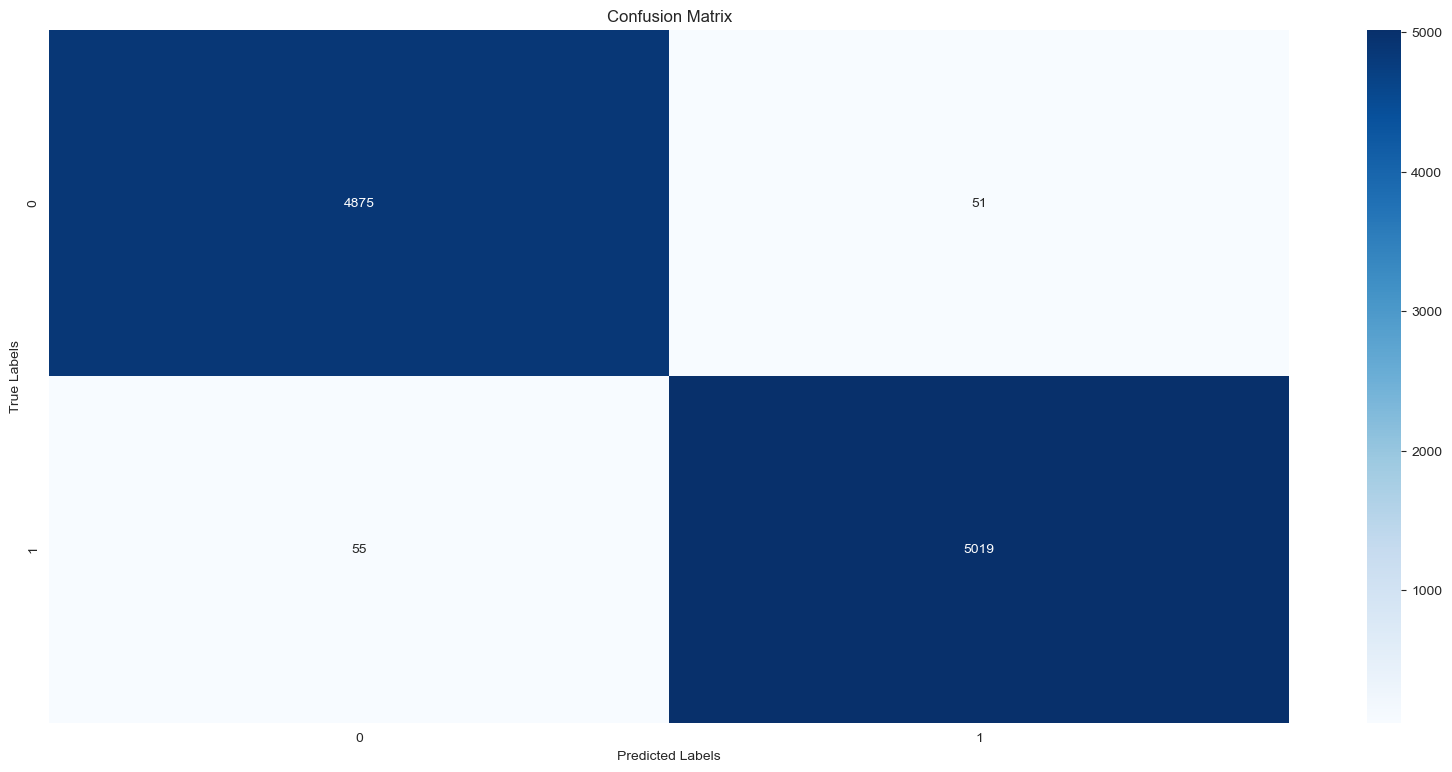

In [33]:
conf_matrix = confusion_matrix(Y_test, best_svm_predictions)
plt.figure(figsize=(20,9))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.title("Confusion Matrix")

In [34]:
print("Metrics:")
print("Accuracy: " + str(accuracy_score(Y_test,best_svm_predictions)))
print("F1-Score: " + str(f1_score(Y_test,best_svm_predictions,average='macro')))
print("Precision: " + str(precision_score(Y_test,best_svm_predictions,average='macro')))
print("Recall: " + str(recall_score(Y_test,best_svm_predictions,average='macro')))

Metrics:
Accuracy: 0.9894
F1-Score: 0.9893978015281248
Precision: 0.9893923208948954
Recall: 0.9894035989643171


### Παρατηρήσεις:
- Σε όλες τις μετρικές το SVM πετυχαίνει υψηλά ποσοστά επιτυχίας, το οποίο μας δείχνει ότι το μοντέλο έχει καλή ικανότητα γενίκευσης και συνεπώς έχουμε την πεποίθηση ότι εάν κάναμε deploy αυτό το μοντέλο θα παραδίδαμε ένα καλό μοντέλο στον πελάτη μας.

## 5. Primal vs Dual space
- Solving the optimization problem in the primal space vs solving it in the dual space.

#### Εκπαίδευση SVM με Linear Kernel
##### Υπάρχουν 2 υλοποιήσεις:
- Έχουμε την υλοποίηση LinearSVC που βασίζεται στην LIBLINEAR και υλοποιεί ένα γραμμικό SVM χρησιμοποιώντας ως αλγόριθμο τον "Dual Coordinate Descent Method". Πρόκειται για έναν επαναληπτικό αλγόριθμο βελτιστοποίησης ο οποίος κάνει βελτιστοποιεί μια μεταβλητή κάθε φορά ενώ κρατάει τις υπόλοιπες σταθερές. Στα θετικά του αλγορίθμου είναι ότι κάνει scale γραμμικά, ενώ στα αρνητικά του είναι το γεγονός ότι δεν υποστηρίζει το kernel trick και άλλους kernels πέρα από τον linear και άρα έχουμε μόνο γραμμικούς ταξινομητές. Η LinearSVC δίνει τη δυνατότητα να λυθεί το πρόβλημα βελτιστοποίησης είτε στον primal είτε στον dual space. Η επίλυση στον dual space απαιτεί την κατασκευή ενός n x n matrix (γνωστός και ως kernel matrix) όπου n είναι το πλήθος των features. Για αυτόν ακριβώς τον λόγο είναι προτιμητέο να λυθεί το πρόβλημα στον primal space στην περίπτωση όπου ο αριθμός των training examples είναι μεγαλύτερος από τον αριθμό των features.
- Υπάρχει και η υλοποίηση SVC που βασίζεται στην libsvm και χρησιμοποιεί ως αλγόριθμο τον "Sequential Minimal Optimization". Στα θετικά του αλγορίθμου είναι ότι υποστηρίζει διάφορους τύπους από kernels και το kernel trick, το οποίο μας επιτρέπει να έχουμε και μη γραμμικούς ταξινομητές, ενώ στα αρνητικά του είναι ότι κάνει scale το λιγότερο Τετραγωνικά, γεγονός που τον καθιστά ιδιαίτερα αργό σε περιπτώσεις όπου το πλήθος των training examples είναι αρκετά μεγάλο (πχ έχουμε εκατοντάδες χιλιάδων training examples). Το πρόβλημα βελτιστοποίησης λύνεται στον dual space.

#### Primal Space

In [30]:
svm_primal = LinearSVC(dual=False,C=1.0,random_state=RANDOM_STATE,max_iter=100000)

#fit
start_time = time.time()
svm_primal.fit(X_train_Manual[:num_of_training_samples],Y_train[:num_of_training_samples])
end_time = time.time()
total_time_fit_svm_primal = end_time - start_time

#predict
start_time = time.time()
svm_primal_predictions = svm_primal.predict(X_test_Manual)
end_time = time.time()
total_time_predict_svm_primal = end_time - start_time

In [31]:
# obtain the support vectors through the decision function
decision_function = svm_primal.decision_function(X_train_Manual)
# we can also calculate the decision function manually
# decision_function = np.dot(X, clf.coef_[0]) + clf.intercept_[0]
# The support vectors are the samples that lie within the margin
# boundaries, whose size is conventionally constrained to 1
support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
support_vectors_primal = X_train_Manual[support_vector_indices]

In [32]:
print(f"Χρόνος εκπαίδευσης: {total_time_fit_svm_primal} seconds.")
print(f"Χρόνος για predictions: {total_time_predict_svm_primal} seconds.")
print("Accuracy: " + str(accuracy_score(Y_test,svm_primal_predictions)))

Χρόνος εκπαίδευσης: 1.1253712177276611 seconds.
Χρόνος για predictions: 0.00999903678894043 seconds.
Accuracy: 0.8938


#### Dual Space με χρήση της LIBLINEAR

In [33]:
svm_dual_liblinear = LinearSVC(dual=True,C=1.0,random_state=RANDOM_STATE,max_iter=100000)

#fit
start_time = time.time()
svm_dual_liblinear.fit(X_train_Manual[:num_of_training_samples],Y_train[:num_of_training_samples])
end_time = time.time()
total_time_fit_svm_dual_liblinear = end_time - start_time

#predict
start_time = time.time()
svm_dual_liblinear_predictions = svm_dual_liblinear.predict(X_test_Manual)
end_time = time.time()
total_time_predict_svm_dual_liblinear = end_time - start_time

In [34]:
# obtain the support vectors through the decision function
decision_function = svm_dual_liblinear.decision_function(X_train_Manual)
# we can also calculate the decision function manually
# decision_function = np.dot(X, clf.coef_[0]) + clf.intercept_[0]
# The support vectors are the samples that lie within the margin
# boundaries, whose size is conventionally constrained to 1
support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
support_vectors_dual_liblinear = X_train_Manual[support_vector_indices]

In [35]:
print(f"Χρόνος εκπαίδευσης: {total_time_fit_svm_dual_liblinear} seconds.")
print(f"Χρόνος για predictions: {total_time_predict_svm_dual_liblinear} seconds.")
print("Accuracy: " + str(accuracy_score(Y_test,svm_dual_liblinear_predictions)))

Χρόνος εκπαίδευσης: 7.9686219692230225 seconds.
Χρόνος για predictions: 0.010000228881835938 seconds.
Accuracy: 0.8936


#### Dual Space με χρήση της Libsvm

In [21]:
svm_dual_libsvm = SVC(C=1.0, kernel="linear",verbose=True,max_iter=100000,random_state=RANDOM_STATE)

#fit
start_time = time.time()
svm_dual_libsvm.fit(X_train_Manual[:num_of_training_samples],Y_train[:num_of_training_samples])
end_time = time.time()
total_time_fit_svm_dual_libsvm = end_time - start_time

#predict
start_time = time.time()
svm_dual_libsvm_predictions = svm_dual_libsvm.predict(X_test_Manual)
end_time = time.time()
total_time_predict_svm_dual_libsvm = end_time - start_time

[LibSVM]

C:\Users\User\anaconda3\envs\MLenv\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [22]:
print(f"Χρόνος εκπαίδευσης: {total_time_fit_svm_dual_libsvm} seconds.")
print(f"Χρόνος για predictions: {total_time_predict_svm_dual_libsvm} seconds.")
print("Accuracy: " + str(accuracy_score(Y_test,svm_dual_libsvm_predictions)))

Χρόνος εκπαίδευσης: 31.64550280570984 seconds.
Χρόνος για predictions: 13.38591718673706 seconds.
Accuracy: 0.8945


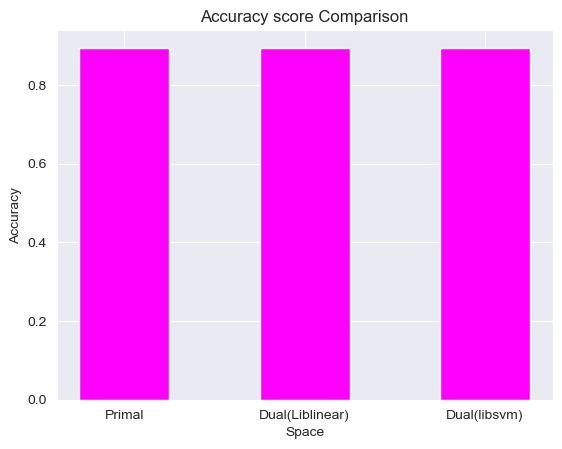

In [36]:
# Data for the bar plot
space = ["Primal", "Dual(Liblinear)", "Dual(libsvm)"]
accuracy = [accuracy_score(Y_test,svm_primal_predictions), accuracy_score(Y_test,svm_dual_liblinear_predictions),accuracy_score(Y_test,svm_dual_libsvm_predictions)]

# Create the bar plot
plt.bar(space, accuracy, color='magenta', width=0.5, align='center')

# Add a title and axis labels
plt.title("Accuracy score Comparison")
plt.xlabel("Space")
plt.ylabel("Accuracy")

# Show the plot
plt.show()

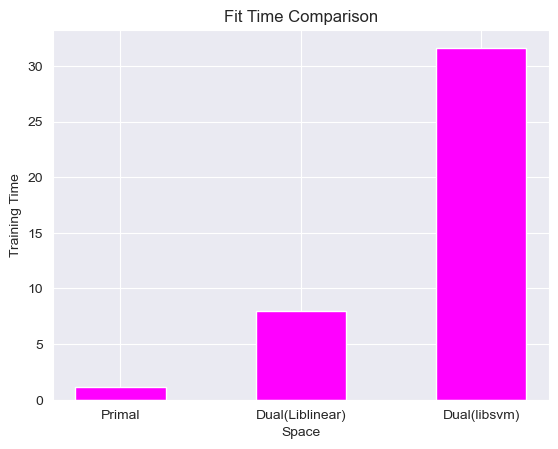

In [40]:
# Data for the bar plot
space = ["Primal", "Dual(Liblinear)", "Dual(libsvm)"]
fit_time = [total_time_fit_svm_primal, total_time_fit_svm_dual_liblinear,total_time_fit_svm_dual_libsvm]

# Create the bar plot
plt.bar(space, fit_time, color='magenta', width=0.5, align='center')

# Add a title and axis labels
plt.title("Fit Time Comparison")
plt.xlabel("Space")
plt.ylabel("Training Time")

# Show the plot
plt.show()

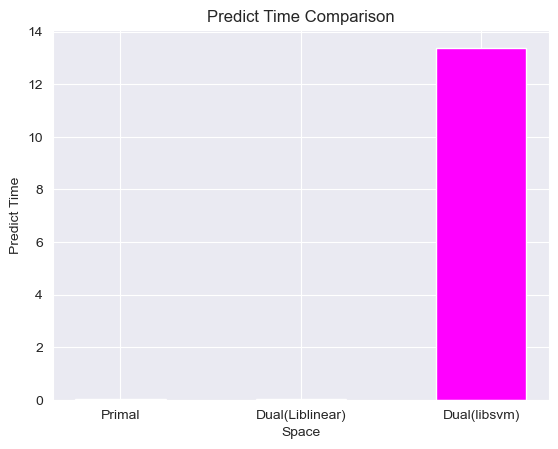

In [37]:
# Data for the bar plot
space = ["Primal", "Dual(Liblinear)", "Dual(libsvm)"]
predict_time = [total_time_predict_svm_primal, total_time_predict_svm_dual_liblinear,total_time_predict_svm_dual_libsvm]

# Create the bar plot
plt.bar(space, predict_time, color='magenta', width=0.5, align='center')

# Add a title and axis labels
plt.title("Predict Time Comparison")
plt.xlabel("Space")
plt.ylabel("Predict Time")

# Show the plot
plt.show()

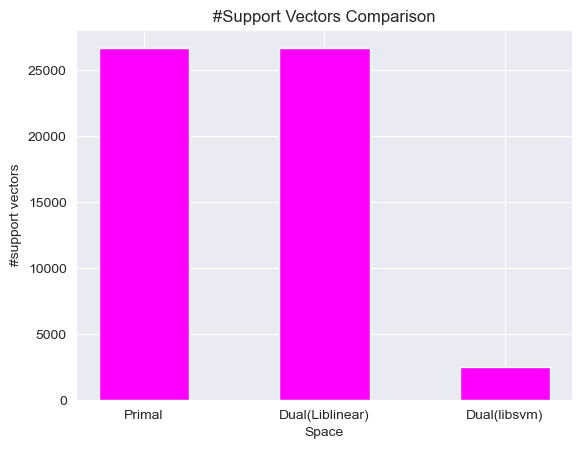

In [38]:
# Data for the bar plot
space = ["Primal", "Dual(Liblinear)", "Dual(libsvm)"]
supp_vectors = [support_vectors_primal.shape[0], support_vectors_dual_liblinear.shape[0],svm_dual_libsvm.support_vectors_.shape[0]]

# Create the bar plot
plt.bar(space, supp_vectors, color='magenta', width=0.5, align='center')

# Add a title and axis labels
plt.title("#Support Vectors Comparison")
plt.xlabel("Space")
plt.ylabel("#support vectors")

# Show the plot
plt.show()

### Παρατηρήσεις:
- Αναφορικά με την Liblinear τόσο στον primal όσο και στον dual space παρατηρούμε ότι πετυχαίνουμε το ίδιο accuracy στα άγνωστα δεδομένα, το οποίο είναι και λογικό καθώς χρησιμοποιείται ο ίδιος αλγόριθμος βελτιστοποίησης και στις δύο περιπτώσεις. Η διαφορά των δύο αναδεικνύεται στους χρόνους εκτέλεσης κατά το training όπου παρατηρούμε ότι το primal space έχει εμφανώς μικρότερο χρόνο εκτέλεσης καθώς δε χρειάζεται να χτίσει τον kernel matrix.
- Παρατηρούμε ότι και τα δύο μοντέλα της Liblinear έχουν πολύ μικρότερους χρόνους εκτέλεσης σε σχέση με το μοντέλο της libsvm στο training phase και αυτό οφείλεται ακριβώς στο γεγονός ότι έχουμε τουλάχιστον τετραγωνική πολυπλοκότητα στην περίπτωση της libsvm σε σχέση με τη γραμμική της liblinear. Για αυτόν τον λόγο εκπαιδεύσαμε τα μοντέλα σε μόλις 10.000 δείγματα γιατί με όλο το Data Set ο αλγόριθμος της libsvm άργησε τόσο πολύ να εκπαιδευτεί οπότε και σταματήσαμε την εκπαίδευσή του.
- Κατά τη φάση του predict παρατηρούμε ότι το μοντέλο της libsvm χρειάζεται πολύ παραπάνω χρόνο παρόλο που έχει πολύ λιγότερα support vectors και άρα χρησιμοποιείται ένα υποσύνολο του kernel matrix. Αυτό οφείλεται στο γεγονός ότι τα δύο μοντέλα της liblinear έχουν αποθηκευμένα το W και το b (δηλαδή το διαχωριστικό υπερεπίπεδο) και επομένως το W<sup>T</sup>*X<sub>test</sub> + b υπολογίζεται πιο γρήγορα σε σχέση με τον υπολογισμό που γίνεται στον dual space, γιατί το διάνυσμα W είναι σε σχετικά μικρή διάσταση(784 διαστάσεις) ενώ ο kernel matrix είναι αρκετά μεγάλος(έχει μέγεθος 10.000 x 10.000).
- Συνεπώς, σε περιπτώσεις όπως είναι το task που λύνουμε, όπου δηλαδή έχουμε μεγάλο πλήθος παραδειγμάτων, τα SVM στον dual space έχουν πρόβλημα λόγω του μεγάλου kernel matrix, ενώ σε προβλήματα όπου έχουμε πολλές διαστάσεις τα SVM έχουν πρόβλημα στον primal space λόγω της μεγάλης διάστασης του W.
- Αναφορικά με την επίδοση σε άγνωστα δεδομένα παρατηρούμε ότι και τα 3 μοντέλα έχουν παρόμοιες αλλά και ικανοποιητικές.

## 6. KNN vs NCC vs SVM
#### Σύγκριση SVM με KNN και Nearest Class Centroid
- Χρησιμοποιούνται τα scaled data και όχι τα original μιας και όλοι αυτοί οι αλγόριθμοι είναι distance based algos και θα επωφεληθούν από το scale των δεδομένων

<h3>K-Nearest Neighbors Classifier</h3>
<h4>Με 1 πλησιέστερο γείτονα (Κ=1)</h4>

In [41]:
knn_1 = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
#fit
start_time = time.time()
knn_1.fit(X_train_Manual,Y_train)
end_time = time.time()
total_time_fit_knn_1 = end_time - start_time

#predict
start_time = time.time()
knn_1_predictions = knn_1.predict(X_test_Manual)
end_time = time.time()
total_time_predict_knn_1 = end_time - start_time

In [42]:
print(f"Χρόνος εκπαίδευσης: {total_time_fit_knn_1} seconds.")
print(f"Χρόνος για predictions: {total_time_predict_knn_1} seconds.")
print("Accuracy: " + str(accuracy_score(Y_test,knn_1_predictions))) # Accuracy (Ορθότητα)

Χρόνος εκπαίδευσης: 19.847646474838257 seconds.
Χρόνος για predictions: 86.72498488426208 seconds.
Accuracy: 0.9838


<h3>K-Nearest Neighbors Classifier</h3>
<h4>Με 3 πλησιέστερους γείτονες (Κ=3)</h4>

In [43]:
knn_3 = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
#fit
start_time = time.time()
knn_3.fit(X_train_Manual,Y_train)
end_time = time.time()
total_time_fit_knn_3 = end_time - start_time

#predict
start_time = time.time()
knn_3_predictions = knn_3.predict(X_test_Manual)
end_time = time.time()
total_time_predict_knn_3 = end_time - start_time

In [44]:
print(f"Χρόνος εκπαίδευσης: {total_time_fit_knn_3} seconds.")
print(f"Χρόνος για predictions: {total_time_predict_knn_3} seconds.")
print("Accuracy: " + str(accuracy_score(Y_test,knn_3_predictions))) # Accuracy (Ορθότητα)

Χρόνος εκπαίδευσης: 19.698973417282104 seconds.
Χρόνος για predictions: 86.38708186149597 seconds.
Accuracy: 0.9852


<h3>Nearest Class Centroid Classifier</h3>

In [45]:
ncc = NearestCentroid()
#fit
start_time = time.time()
ncc.fit(X_train_Manual,Y_train)
end_time = time.time()
total_time_fit_ncc = end_time - start_time

#predict
start_time = time.time()
ncc_predictions = ncc.predict(X_test_Manual)
end_time = time.time()
total_time_predict_ncc = end_time - start_time

In [46]:
print(f"Χρόνος εκπαίδευσης: {total_time_fit_ncc} seconds.")
print(f"Χρόνος για predictions: {total_time_predict_ncc} seconds.")
print("Accuracy: " + str(accuracy_score(Y_test,ncc_predictions))) # Accuracy (Ορθότητα)

Χρόνος εκπαίδευσης: 0.12000155448913574 seconds.
Χρόνος για predictions: 0.029999732971191406 seconds.
Accuracy: 0.8026


### Linear SVM

In [52]:
svm = LinearSVC(dual=False,C=1.0,random_state=RANDOM_STATE,max_iter=100000)

#fit
start_time = time.time()
svm.fit(X_train_Manual,Y_train)
end_time = time.time()
total_time_fit_svm = end_time - start_time

#predict
start_time = time.time()
svm_predictions = svm.predict(X_test_Manual)
end_time = time.time()
total_time_predict_svm = end_time - start_time

In [53]:
print(f"Χρόνος εκπαίδευσης: {total_time_fit_svm} seconds.")
print(f"Χρόνος για predictions: {total_time_predict_svm} seconds.")
print("Accuracy: " + str(accuracy_score(Y_test,svm_predictions))) # Accuracy (Ορθότητα)

Χρόνος εκπαίδευσης: 15.424603462219238 seconds.
Χρόνος για predictions: 0.009079217910766602 seconds.
Accuracy: 0.9012


##### Bar Plots

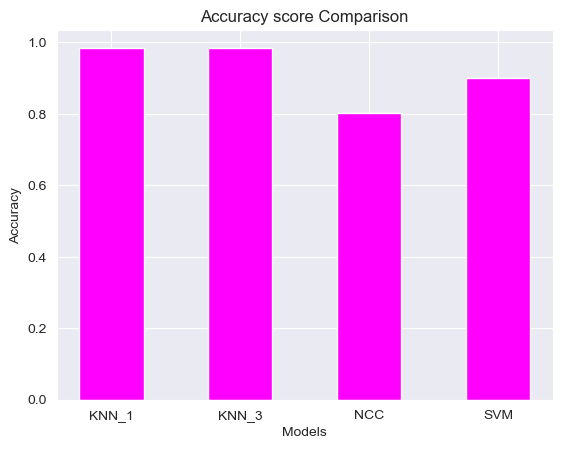

In [54]:
# Data for the bar plot
models = ["KNN_1", "KNN_3", "NCC", "SVM"]
accuracy = [accuracy_score(Y_test,knn_1_predictions), accuracy_score(Y_test,knn_3_predictions),accuracy_score(Y_test,ncc_predictions),accuracy_score(Y_test,svm_predictions)]

# Create the bar plot
plt.bar(models, accuracy, color='magenta', width=0.5, align='center')

# Add a title and axis labels
plt.title("Accuracy score Comparison")
plt.xlabel("Models")
plt.ylabel("Accuracy")

# Show the plot
plt.show()

#### Παρατηρούμε ότι ο ΚΝΝ έχει καλύτερη απόδοση σε σχέση με τα υπόλοιπα μοντέλα.
#### Υπάρχουν διάφοροι λόγοι για τους οποίους ενδέχεται ο KNN τα πήγε καλύτερα από το SVM με τον κυριότερο να είναι ότι χρησιμοποιήσαμε ένα γραμμικό SVM που έχει μικρό capacity.
### There are a few factors that may make KNN better than SVM for a particular classification task:
- KNN is simpler and easier to implement than SVM, and it may require less tuning of hyperparameters.
- KNN may perform better on datasets with a large number of features, while SVM may perform better on datasets with a small number of features.
- KNN may perform better on datasets with a non-linear decision boundary, while SVM may perform better on datasets with a linear decision boundary.

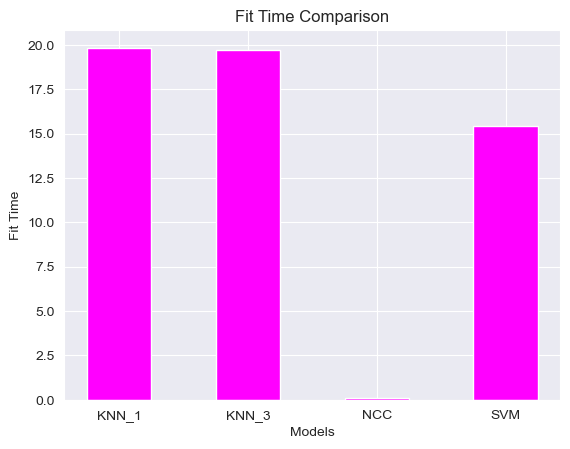

In [55]:
# Data for the bar plot
models = ["KNN_1", "KNN_3", "NCC", "SVM"]
fit_time = [total_time_fit_knn_1, total_time_fit_knn_3,total_time_fit_ncc,total_time_fit_svm]

# Create the bar plot
plt.bar(models, fit_time, color='magenta', width=0.5, align='center')

# Add a title and axis labels
plt.title("Fit Time Comparison")
plt.xlabel("Models")
plt.ylabel("Fit Time")

# Show the plot
plt.show()

Παρατηρούμε ότι ο ΚΝΝ χρειάζεται περισσότερο χρόνο εκπαίδευσης σε σχέση με τα άλλα δύο μοντέλα

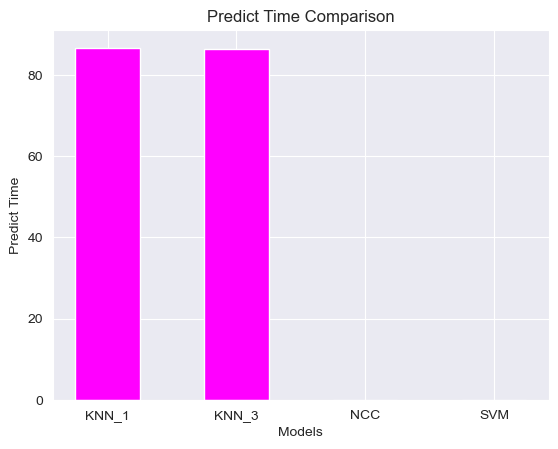

In [56]:
# Data for the bar plot
models = ["KNN_1", "KNN_3", "NCC", "SVM"]
predict_time = [total_time_predict_knn_1, total_time_predict_knn_3,total_time_predict_ncc,total_time_predict_svm]

# Create the bar plot
plt.bar(models, predict_time, color='magenta', width=0.5, align='center')

# Add a title and axis labels
plt.title("Predict Time Comparison")
plt.xlabel("Models")
plt.ylabel("Predict Time")

# Show the plot
plt.show()

Παρατηρούμε ότι ο ΚΝΝ χρειάζεται περισσότερο χρόνο εκπαίδευσης σε σχέση με τα άλλα δύο μοντέλα

## 7. Παραδείγματα Ορθής και Εσφαλμένης Κατηγοριοποίησης

<h3>Παράδειγμα Εσφαλμένης κατηγοριοποίησης</h3>

In [59]:
#Κάνουμε ένα μικρό pre-process για να μπορέσουμε να εντοπίσουμε πιο εύκολα παραδείγματα εσφαλμένης κατηγοριοποίησης

# Ενώνουμε τα X_test και Y_test
Y_test_expanded = np.expand_dims(Y_test,axis=1)
Test_set = np.hstack((X_test,Y_test_expanded))
# Μαζεύουμε όλα τα παραδείγματα της κάθε κλάσης μαζί (Δηλαδή στην αρχή του Data Set έχουμε όλα τα training examples με label ίσο με 0, στη συνέχεια όλα τα training examples με label ίσο με 1, κ.ο.κ)
Sorted_test_set = Test_set[Test_set[:, 784].argsort()]
# Κάνουμε split τα X_train και Y_train
Y_test_sorted = Sorted_test_set[:, -1] # for last column
X_test_sorted = Sorted_test_set[:, :-1] # for all but last column

# predictions
svm_predictions_sorted = svm.predict(X_test_sorted)

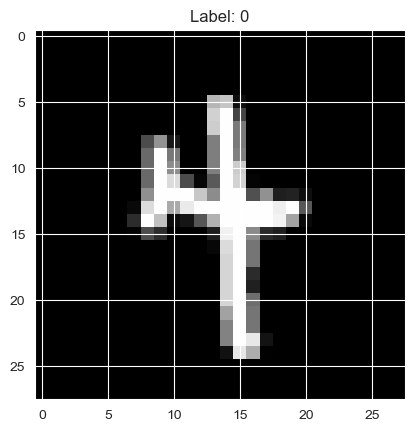

Prediction: 1
Correct Label: 0


In [80]:
plt.imshow(np.reshape(X_test_sorted[31],(28,28)), cmap='gray', vmin=0, vmax=255)
plt.title(f"Label: {Y_test_sorted[31]}")
plt.show()
print(f"Prediction: {svm_predictions_sorted[31]}")
print(f"Correct Label: {Y_test_sorted[31]}")

### Παρατηρούμε ότι το SVM πρόβλεψε ότι πρόκειται περιττό αριθμό, ενώ στην πραγματικότητα ήταν περιττός. Αυτό οφείλεται πιθανώς στο γεγονός ότι το μοντέλο δεν κατάλαβε ότι πρόκειται για ένα τεσσάρι αλλά μάλλον ένα εφτάρι ή ένας άσσος και για αυτό το έκανε classify ως περιττό.

<h3>Παράδειγμα Ορθής κατηγοριοποίησης</h3>

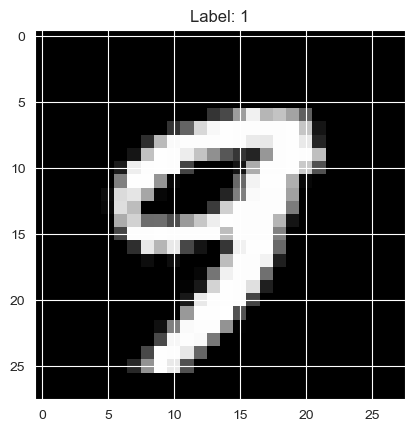

Prediction: 1
Correct Label: 1


In [81]:
plt.imshow(np.reshape(X_test_sorted[5000],(28,28)), cmap='gray', vmin=0, vmax=255)
plt.title(f"Label: {Y_test_sorted[5000]}")
plt.show()
print(f"Prediction: {svm_predictions_sorted[5000]}")
print(f"Correct Label: {Y_test_sorted[5000]}")

<h4>Παρατηρούμε στην εικόνα ότι πρόκειται για ένα "καλοσχεδιασμένο" 9 και συνεπώς το μοντέλο δε δυσκολεύεται στο να προβλέψει ορθά το ψηφίο και να το κάνει classify ως περιττό.</h4>